# Plot SARI timeseries

### Setup

In [1]:
import sys
sys.path.append('../')
from src.hp_tuning_functions import *
from src.realtime_utils import *

In [2]:
params

NameError: name 'params' is not defined

In [7]:
params_old = {'lags': 8,
 'max_bin': 1024,
 'max_depth': -1,
 'reg_alpha': 0.5,
 'subsample': 0.8,
 'num_leaves': 10,
 'reg_lambda': 0.5,
 'n_estimators': 2000,
 'learning_rate': 0.1,
 'min_split_gain': 0.1,
 'subsample_freq': 2,
 'colsample_bytree': 0.8,
 'min_child_samples': 20,
 'lags_past_covariates': 8,
 'use_static_covariates': False,
 'lags_future_covariates': [0, 4]}

In [8]:
name = params.pop('model')
multiple_series = params.pop('multiple_series')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')
sample_weight = params.pop('sample_weight')

if not use_covariates:
    del params['lags_past_covariates']

model = LightGBMModel(
    **params,
    output_chunk_length=HORIZON,
    add_encoders=ENCODERS if use_encoders else None,
    likelihood="quantile",
    quantiles=QUANTILES,
    verbose=-1,
)

In [71]:
from plotnine import *

# Load data

In [4]:
targets, covariates = load_realtime_training_data()

In [5]:
df = targets.pd_dataframe().reset_index()

In [6]:
df.columns

Index(['date', 'icosari-sari-DE', 'icosari-sari-00-04', 'icosari-sari-05-14',
       'icosari-sari-15-34', 'icosari-sari-35-59', 'icosari-sari-60-79',
       'icosari-sari-80+'],
      dtype='object', name='component')

In [7]:
test_end = get_season_end(2023)
validation_end = get_season_end(2022)
train_end = get_season_end(2021)

In [8]:
highlight_areas = pd.DataFrame({
    "xmin": [targets.start_time(), train_end, validation_end],
    "xmax": [train_end, validation_end, test_end],
    "period": ["Train", "Validation", "Test"]  
})

In [9]:
targets = targets[:test_end]

In [10]:
covid_start = pd.Timestamp("2020-03-11")

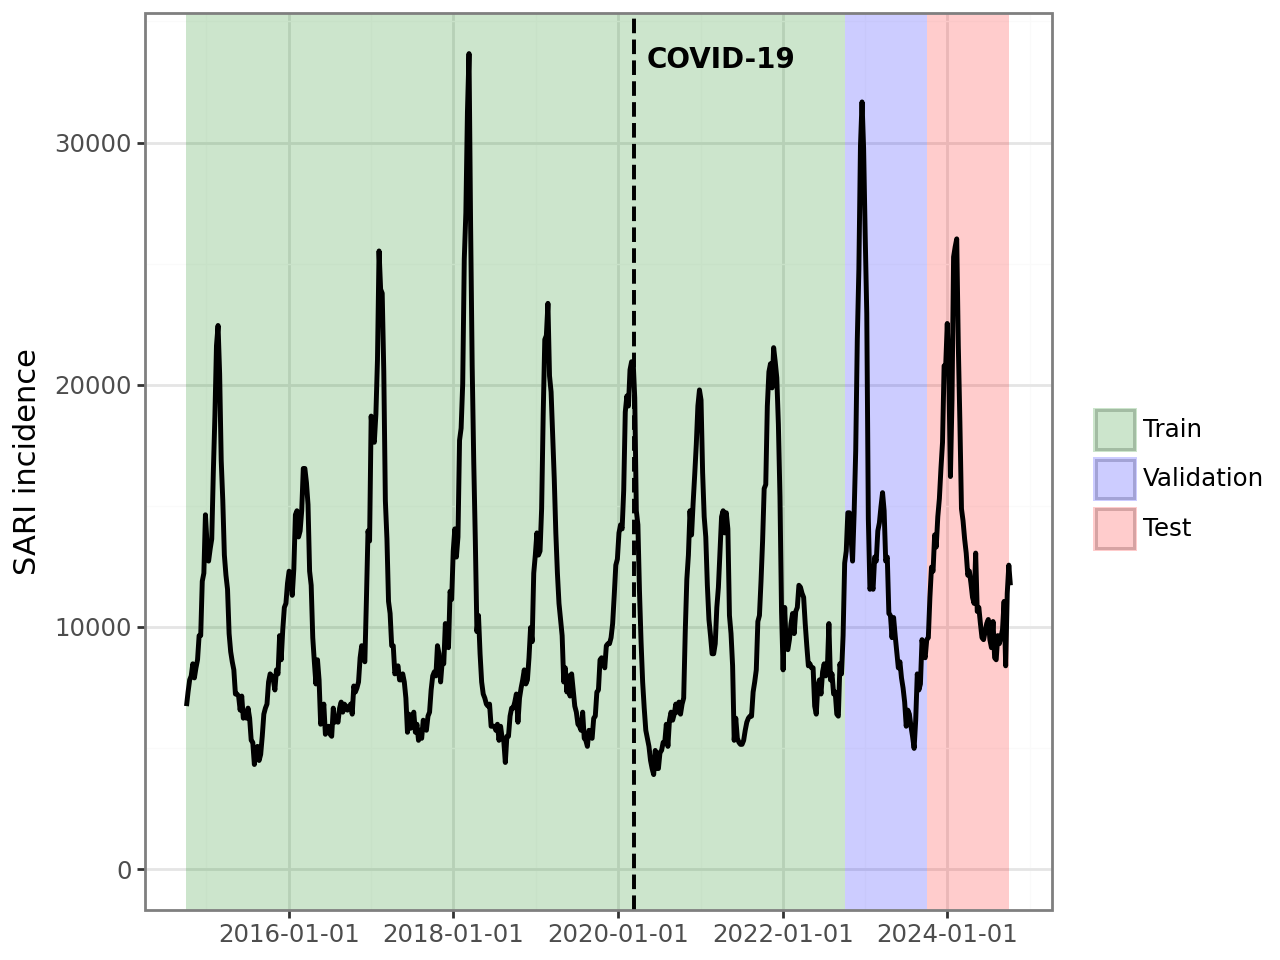

In [11]:
plot = (
    ggplot() +
    
    # Use geom_rect with the highlight_areas DataFrame and map fill to the label
    geom_rect(
        data=highlight_areas,
        mapping=aes(xmin="xmin", xmax="xmax", ymin=-float("inf"), ymax=float("inf"), fill="period"),
        alpha=0.2
    ) +
    
    # Vertical dashed line at the start of COVID-19
    geom_vline(
        xintercept=covid_start,
        linetype="dashed",
        color="black",
        size=0.8
    ) +
    
    # Label for COVID-19 start
    annotate(
        "text",
        x=covid_start + pd.Timedelta(weeks=8),
        y=df['icosari-sari-DE'].max() * 0.975,  # Slightly below the max y value for positioning
        label="COVID-19",
        ha="left",  # Align text to the left of the line
        va="bottom",  # Position text just above the line
        size=10,
        color="black",
        fontweight="bold"
    ) +
    
    # Add the time series line
    geom_line(df, aes(x='date', y='icosari-sari-DE'), size=1) +
    
    # Customize labels and scales
    labs(
        x="",
        y="SARI incidence",
        fill=""  # Legend title for the areas
    ) +
    scale_x_date(date_breaks='2 year', minor_breaks='1 year') +
    scale_y_continuous(limits=(0, None)) +
    
    # Define colors for each period in the legend
    scale_fill_manual(values={
        "Train": "green",
        "Validation": "blue",
        "Test": "red"
    }, limits=["Train", "Validation", "Test"]) + # To order the legend
    
    # Customize theme
    theme_bw() +
    theme(legend_position="right")
)

plot

In [83]:
# plot.save("../figures/sari_periods.pdf", width = 180, height = 90, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 180.00000000000003 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/sari_periods.pdf


# Different data versions

In [159]:
date1 = '2023-12-07'
date2 = '2024-01-07'

df1 = load_target_series(as_of=date1)
df2 = load_target_series(as_of=date2)

latest_sari = load_latest_series('sari')

df2 = concatenate([latest_sari.drop_after(df2.start_time()), df2])

In [175]:
# df2['icosari-sari-DE'][pd.Timestamp('2023-06-01'):].plot()
# df1['icosari-sari-DE'][pd.Timestamp('2023-06-01'):].plot()

In [164]:
start = pd.Timestamp('2023-07-01')

df1 = df1['icosari-sari-DE'][start:].pd_dataframe().reset_index()
df2 = df2['icosari-sari-DE'][start:].pd_dataframe().reset_index()

df1['data_version'] = date1
df2['data_version'] = date2

df = pd.concat([df1, df2])

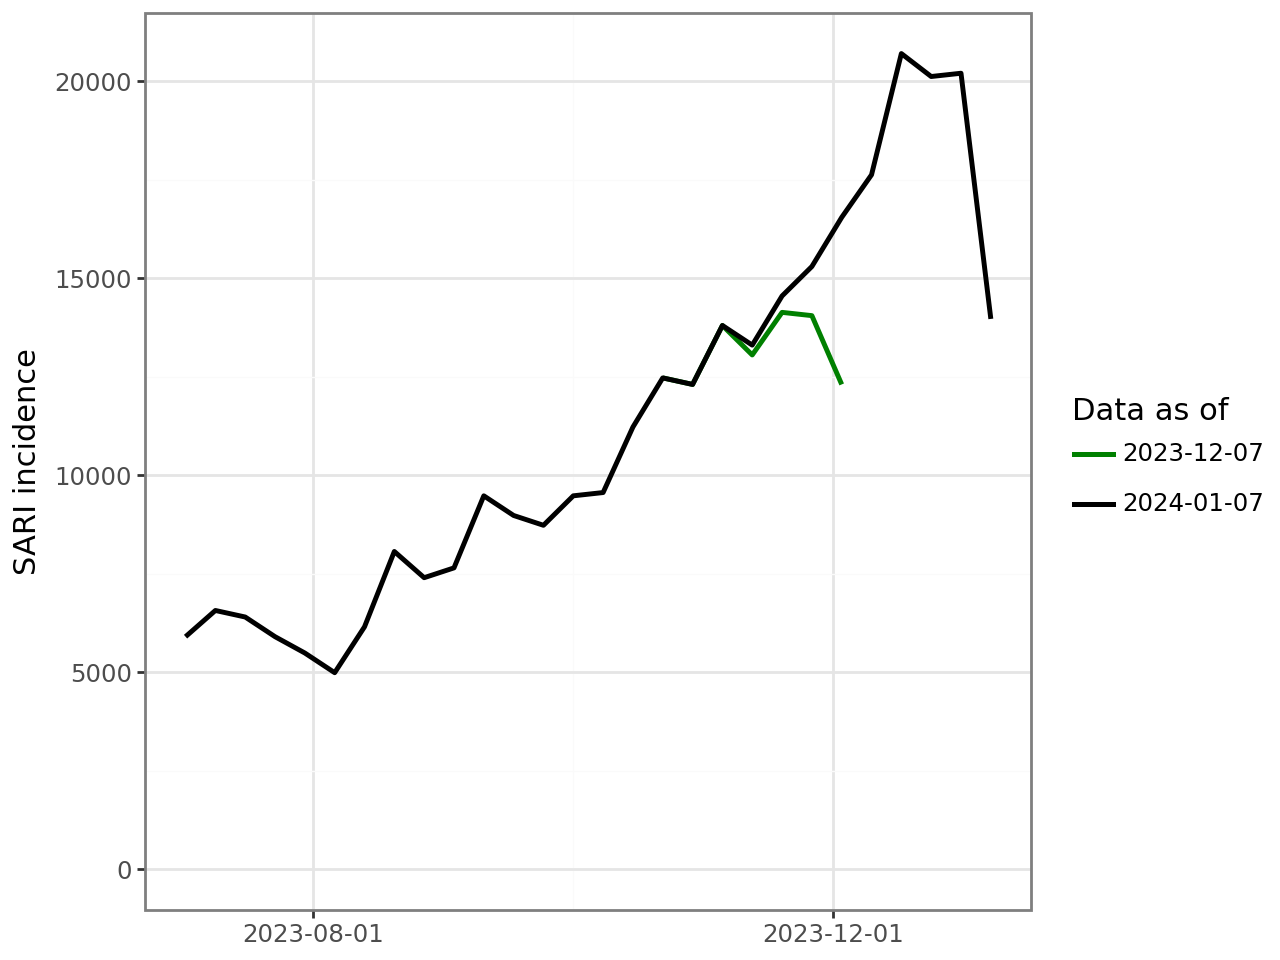

In [173]:
plot = (
    ggplot() +
    geom_line(df, aes(x='date', y='icosari-sari-DE', color='data_version'), size=1) +
    
    # Customize labels and scales
    labs(
        x="",
        y="SARI incidence",
        color="Data as of"
    ) +
    scale_x_date( # date_breaks='4 month', minor_breaks='1 month'
     breaks=[pd.Timestamp('2023-08-01'), pd.Timestamp('2023-12-01')]
    ) +
    scale_y_continuous(limits=(0, None)) +
    
    # Define colors for each period in the legend
    scale_color_manual(values={
        date1: "green",
        date2: "black",
    }, limits=[date1, date2]) + # To order the legend
    
    # Customize theme
    theme_bw() +
    theme(legend_position="right",
          legend_key=element_blank())
)

plot

In [174]:
plot.save("../figures/revision.pdf", width = 90, height = 90, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 90.00000000000001 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/revision.pdf
